# Objective

Tune parameters for LocalMaxPeakFinder (LMP) using RCA image round 0 channel 1.

In [109]:
import pandas as pd
import numpy as np
import os, warnings
from instapipeline import QuantiusAnnotation, SpotAnnotationAnalysis, param
from starfish.image import Filter, data
from starfish.spots import FindSpots
from starfish.types import Axes

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from skimage.io import imread

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

In [6]:
margin = 4					# margin around each spot, in pixels
correctness_threshold = 10
max_num_crops = 7
colors = ['cyan', 'blue', 'purple', 'violet', 'magenta', 'red', 'orange', 'yellow', 'green', ]    
crosshair_ratio = 0.04
max_num_crops = 4
max_crowded_ratio = 0.3
clustering_params = ['AffinityPropagation', -350]
declumping_params = ['KMeans', 2]
origins = ['expert', 'consensus']
correctness_threshold = 10

#### Get combined (worker + expert consensus) annotations, cluster, and QC.
(Consensus-alone annotations are produced in `pipeline_test_RCA.ipynb`.)

In [38]:
test_img_filename = 'ISS_rnd0_ch1_z0'
crops_path = './crops/%s/' % test_img_filename
json_filepath = './anno/%s.json' % test_img_filename
img_filenames = [f for f in os.listdir(crops_path) if f.endswith('.png')]
expert_path = './test_images_filtered/coords/%s.csv' % test_img_filename
anno_expert = pd.read_csv(expert_path)

for img_filename in img_filenames:
    print('Now processing %s' % (img_filename))
    
    img_filepath = './crops/%s/%s' % (test_img_filename, img_filename)
    
    # load worker annotations
    qa = QuantiusAnnotation(json_filepath, img_filename)
    sa = SpotAnnotationAnalysis(qa)
    anno_all = qa.df()

    # add in expert annotations,
    # which have to be selected and scaled to match crop
    stats_path = crops_path + img_filename[:-4] + '.csv'
    stats = np.asarray(pd.read_csv(stats_path, header = None))
    xmin, xmax, ymin, ymax, zoom_factor = [x[0] for x in stats]
    temp = anno_expert[anno_expert.col >= xmin]
    temp = temp[temp.col <= xmax]
    temp = temp[temp.row >= ymin]
    temp = temp[temp.row <= ymax]
    anno_expert_scaled = pd.DataFrame()
    anno_expert_scaled['y'] = list((temp.row-ymin)*zoom_factor)
    anno_expert_scaled['x'] = list((temp.col-xmin)*zoom_factor)
    anno_expert_scaled['timestamp'] = [0]*len(temp)
    anno_expert_scaled['annotation_type'] = ['added']*len(temp)
    anno_expert_scaled['height'] = ['1047']*len(temp)
    anno_expert_scaled['width'] = ['1390']*len(temp)
    anno_expert_scaled['image_filename'] = ['ISS_rnd0_ch1_z0_2_0.png']*len(temp)
    anno_expert_scaled['time_when_completed'] = ['0']*len(temp)
    anno_expert_scaled['worker_id'] = ['expert']*len(temp)
    anno_combined = pd.concat([anno_all, anno_expert_scaled])
    
    # cluster annotations
    clusters = sa.get_clusters(anno_combined, clustering_params)

    # apply QC
    cluster_size_threshold = clus.get_cluster_size_threshold(clusters)
    small_clusters, large_clusters = clus.sort_clusters_by_size(clusters, cluster_size_threshold)

    clumpiness_threshold = clus.get_clumpiness_threshold(large_clusters)
    clumpy_clusters, nonclumpy_clusters = clus.sort_clusters_by_clumpiness(large_clusters, clumpiness_threshold)
    clusters_post_qc = nonclumpy_clusters

    if len(clumpy_clusters.index) is not 0:
        for i in range(len(clumpy_clusters.index)):
            subclusters = clus.declump(clumpy_clusters, i, declumping_params)
        clusters_post_qc = pd.concat([subclusters, clusters_post_qc], ignore_index=True)

    # save consensus coords        
    im = imread(img_filepath)
    img_height = len(im)
    clusters_post_qc_list = []
    for index in clusters_post_qc.index:
        row = clusters_post_qc.iloc[index]
        x, y = row['centroid_x'], row['centroid_y']
        clusters_post_qc_list.append([x, img_height-y])
    path = ('./consensus_combined/%s' % img_filename).replace('png', 'csv')

#### Reassemble crops for combined (worker + expert consensus) annotations.

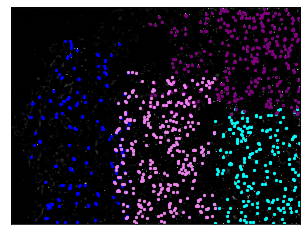

In [21]:
test_img_filename = 'ISS_rnd0_ch1_z0'
crops_path = './crops/%s/' % test_img_filename
consensus_path = './consensus_combined/%s/' % test_img_filename
consensus_csv_names = [f for f in os.listdir(consensus_path) if f.endswith('.csv')]

consensus_csv_names_deep = [f for f in consensus_csv_names if f.startswith('ISS_rnd0_ch1_z0_2')]
total_deep = np.asarray(pd.read_csv('./consensus_combined/ISS_rnd0_ch1_z0/ISS_rnd0_ch1_z0_2_blacked.csv')).tolist()
for i in range(max_num_crops):
    name = 'ISS_rnd0_ch1_z0_2_' + str(i) + '.csv'
    coords = np.asarray(pd.read_csv(consensus_path + name)) # flag
    stats = np.asarray(pd.read_csv(crops_path + name, header = None))
    xmin = float(stats[0][0])
    ymin = float(stats[2][0])
    ymax = float(stats[3][0])
    height = ymax - ymin
    zoom_factor = stats[4][0]

    for coord in coords:
        x = coord[0]/zoom_factor + xmin
        y = coord[1]/zoom_factor + ymin
        total_deep.append([x, y])
        
np.savetxt('./consensus_combined/ISS_rnd0_ch1_z0/ISS_rnd0_ch1_z0_2.csv', np.asarray(total_deep),
           delimiter=",", comments='', header='centroid_x,centroid_y')

test_img_path = './test_images_filtered/images/%s.png' % test_img_filename
blacked_path = './consensus_combined/' + test_img_filename + '/' + test_img_filename + '_blacked.csv'
total = []
coords_blacked = np.asarray(pd.read_csv(blacked_path))

for coord in coords_blacked:
    plt.scatter(coord[0], coord[1], color = 'black')
    total.append([coord[0], coord[1]])

for i in range(4):
    coords_path = './consensus_combined/' + test_img_filename + '/' + test_img_filename + '_' + str(i) + '.csv'
    coords = np.asarray(pd.read_csv(coords_path))
    stats_path = './crops/' + test_img_filename + '/' + test_img_filename + '_' + str(i) + '.csv'
    stats = np.asarray(pd.read_csv(stats_path, header = None))
    xmin = stats[0][0]
    ymin = stats[2][0]
    ymax = stats[3][0]
    height = ymax - ymin
    zoom_factor = stats[4][0]

    refit = []
    for coord in coords:
        x = coord[0]/zoom_factor + xmin
        y = coord[1]/zoom_factor + ymin
        refit.append([x, y])
        total.append([x, y])
    refit = np.asarray(refit)

    for coord in refit:
        plt.scatter(coord[0], coord[1], color=colors[i], s=5)

im = imread(test_img_path, as_gray=True)
plt.imshow(im, cmap='gray')

plt.xticks([])
plt.yticks([])
plt.savefig('consensus_combined_%s.pdf' % test_img_filename, transparent=True, bbox_inches="tight")
np.savetxt('./consensus_combined/' + test_img_filename + '/total.csv', np.asarray(total), delimiter=",",
           comments='', header='centroid_x,centroid_y')
plt.show()

#### Load data from starfish.

In [7]:
round_ind = 0
channel_ind = 1
stringencies = range(21)
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.ISS(use_test_data=use_test_data)
fov = experiment.fov()
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)

#### Get and save LMP blobs.

In [9]:
if not os.path.exists('./blobs_lmp/'):
    os.mkdir('./blobs_lmp/')

In [8]:
use_test_data = os.getenv("USE_TEST_DATA") is not None
experiment = data.ISS(use_test_data=use_test_data)
fov = experiment.fov()
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)

# filter raw data
masking_radius = 15
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
filtered_imgs = filt.run(imgs, verbose=True, in_place=False)

100%|██████████| 16/16 [00:00<00:00, 151.54it/s]


In [11]:
for stringency in stringencies:

    print(stringency)

    test_img_path = './test_images_filtered/images/%s.png' % test_img_filename
    im = imread(test_img_path, as_gray=True)
    img_height = len(im)

    # slice the ImageStack
    sel={Axes.ROUND: round_ind, Axes.CH: channel_ind, Axes.ZPLANE: 0}
    single_plane_filtered = filtered_imgs.sel(sel)

    lmp = FindSpots.LocalMaxPeakFinder(
        min_distance=6,
        stringency=stringency,
        min_obj_area=6,
        max_obj_area=600,
    )

    new_stack = single_plane_filtered.from_numpy(single_plane_filtered.xarray.values) 
    intensities = lmp.run(new_stack)
    spots = intensities[:, 0, 0].where(intensities[:, 0, 0] != 0, drop=True)
    x_vals = spots.x.values
    y_vals = spots.y.values

    blobs = []
    for x, y in zip(x_vals, y_vals):
        blobs.append([x, y])
    blobs = np.asarray(blobs)

    path = './blobs_lmp/%s_%s.csv' % (test_img_filename, stringency)
    np.savetxt(path, blobs, delimiter=",")

Get precision and recall based on expert-alone and consensus-alone ground truth.

In [34]:
precision_recall = []
expert_path = './test_images_filtered/coords/%s.csv' % test_img_filename
consensus_path = './consensus/%s/total.csv' % test_img_filename

for stringency in stringencies:
    print(stringency)
    for origin in origins:
        ref_path = expert_path if origin=='expert' else consensus_path
        ref_coords = np.asarray(pd.read_csv(ref_path))  
        # calc precision and recall
        precision, recall = param.get_precision_recall(test_coords=blobs,
                                                       ref_coords=ref_coords,
                                                       correctness_threshold=correctness_threshold)
        precision_recall.append((precision, recall))

        blobs = np.asarray(pd.read_csv('./blobs_lmp_4/%s_%s.csv' % (test_img_filename, stringency), header=None))
np.savetxt('./blobs_lmp_0_1/precision_recall.csv', precision_recall, delimiter=",")

Get precision and recall based on expert-and-consensus combined ground truth.

In [69]:
combined_path = './consensus_combined/%s/total.csv' % test_img_filename
precision_recall_combined = []
for stringency in stringencies:
    print(stringency)
    ref_coords = np.asarray(pd.read_csv(combined_path))  
    blobs = np.asarray(pd.read_csv('./blobs_lmp_4/%s_%s.csv' % (test_img_filename, stringency), header=None))
    precision, recall = param.get_precision_recall(test_coords=blobs,
                                                   ref_coords=ref_coords,
                                                   correctness_threshold=correctness_threshold)
    precision_recall_combined.append((precision, recall))
np.savetxt('./blobs_lmp_0_1/precision_recall_combined.csv', precision_recall_combined, delimiter=",")

Get plot data.

In [88]:
precision_recall_indiv = np.asarray(pd.read_csv('./blobs_lmp_0_1/precision_recall.csv', header=None))
expert_precision_recall, consensus_precision_recall = [], []
for ind, pr in enumerate(precision_recall_indiv):
    p, r = pr
    if ind % 2 == 0:
        expert_precision_recall.append([p,r])
    else:
        consensus_precision_recall.append([p,r])
precision_recall_combined = np.asarray(pd.read_csv('./blobs_lmp_0_1/precision_recall_combined.csv', header=None))

combined_precision = precision_recall_combined[:,0]
expert_precision = [x[0] for x in expert_precision_recall]
consensus_precision = [x[0] for x in consensus_precision_recall]

expert_recall = [x[1] for x in expert_precision_recall]
consensus_recall = [x[1] for x in consensus_precision_recall]
combined_recall = precision_recall_combined[:,1]

expert_precision_x_recall = [x * y for x, y in zip(expert_precision, expert_recall)]
consensus_precision_x_recall = [x * y for x, y in zip(consensus_precision, consensus_recall)]
combined_precision_x_recall = [x * y for x, y in zip(combined_precision, combined_recall)]

## MT Figure 5

In [103]:
axis_label_size = 13

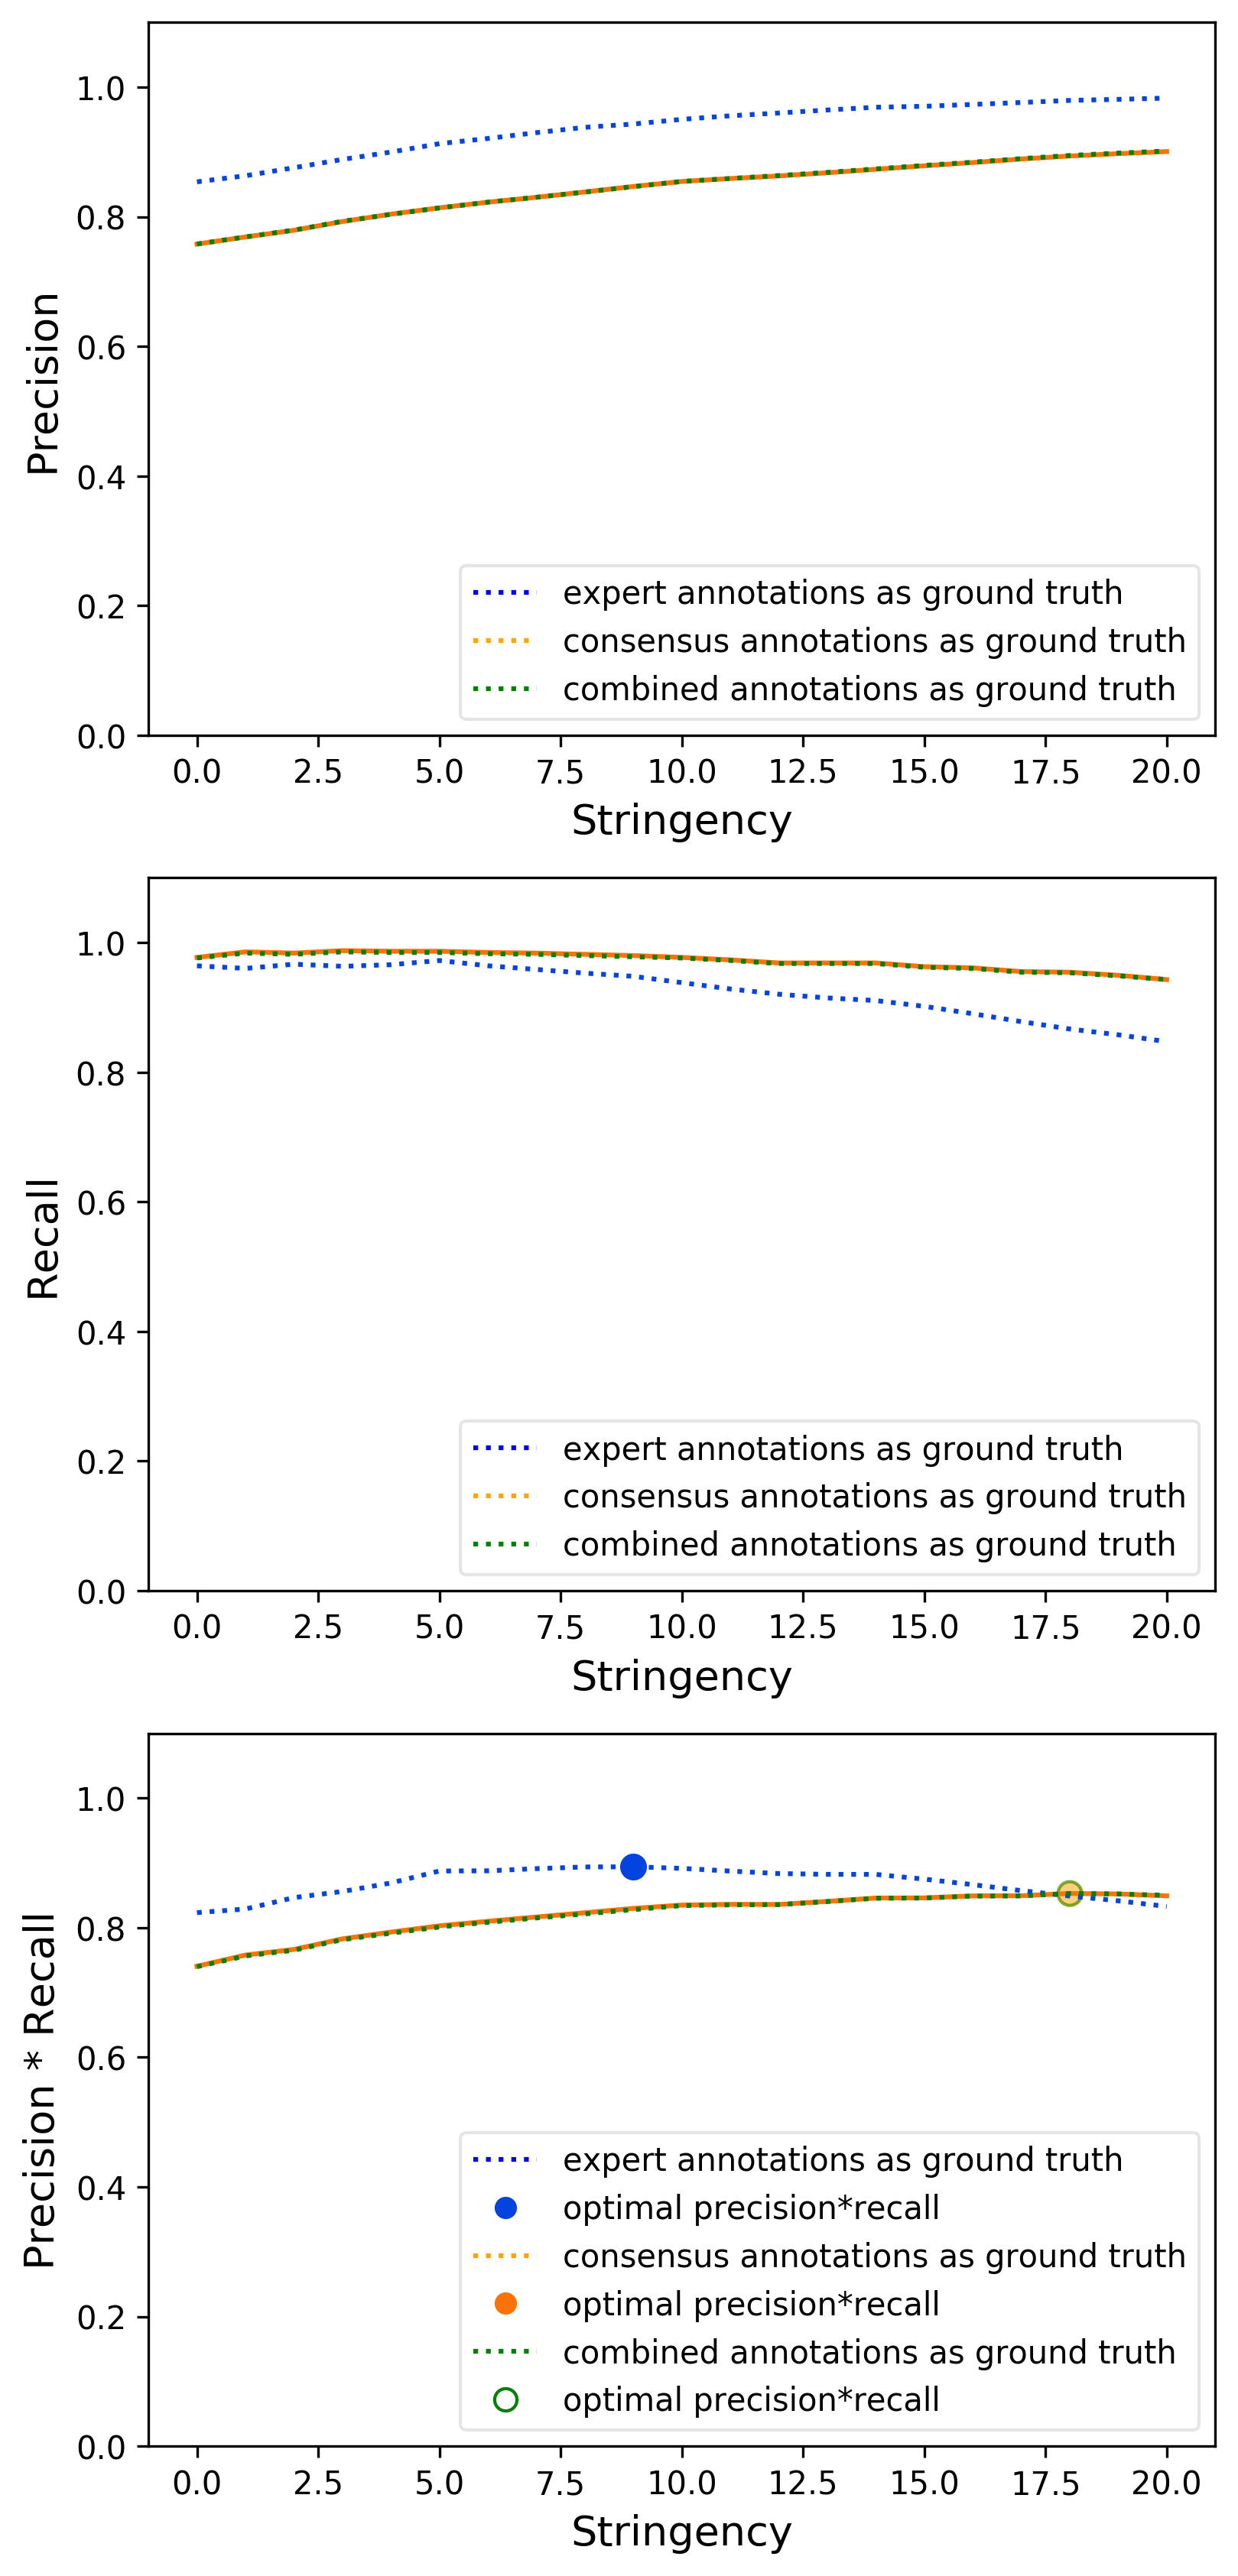

In [106]:
fig, ax = plt.subplots(3, figsize=(6,14), dpi=300)
ax[0].plot(stringencies, consensus_precision, c='xkcd:orange', ls='-')
ax[0].plot(stringencies, expert_precision, c='xkcd:blue', ls=':')
ax[0].plot(stringencies, combined_precision, c='g', ls=':')
leg_elem_1 = Line2D([0], [0], marker='None', color='b', label='expert annotations as ground truth', ls=':')
leg_elem_2 = Line2D([0], [0], marker='None', color='orange', label='consensus annotations as ground truth', ls=':')
leg_elem_3 = Line2D([0], [0], marker='None', color='g', label='combined annotations as ground truth', ls=':')

handle_list = [leg_elem_1, leg_elem_2, leg_elem_3]
ax[0].legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':10}, framealpha=0.5)
ax[0].set_xlabel('Stringency', fontsize=axis_label_size)
ax[0].set_ylabel('Precision', fontsize=axis_label_size)
ax[0].set_ylim(0, 1.1)

ax[1].plot(stringencies, consensus_recall, c='xkcd:orange', ls='-')
ax[1].plot(stringencies, expert_recall, c='xkcd:blue', ls=':')
ax[1].plot(stringencies, combined_recall, c='g', ls=':')

leg_elem_1 = Line2D([0], [0], marker='None', color='b', label='expert annotations as ground truth', ls=':')
leg_elem_2 = Line2D([0], [0], marker='None', color='orange', label='consensus annotations as ground truth', ls=':')
leg_elem_3 = Line2D([0], [0], marker='None', color='g', label='combined annotations as ground truth', ls=':')
handle_list = [leg_elem_1, leg_elem_2, leg_elem_3]
ax[1].legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':10}, framealpha=0.5)

ax[1].set_xlabel('Stringency', fontsize=axis_label_size)
ax[1].set_ylabel('Recall', fontsize=axis_label_size)
ax[1].set_ylim(0, 1.1)

ax[2].plot(stringencies, consensus_precision_x_recall, c='xkcd:orange', ls='-')
ax[2].plot(stringencies, expert_precision_x_recall, c='xkcd:blue', ls=':')
ax[2].plot(stringencies, combined_precision_x_recall, c='g', ls=':')

ax[2].scatter([stringencies[expert_precision_x_recall.index(max(expert_precision_x_recall))]], [max(expert_precision_x_recall)], color='xkcd:blue', s=55)
ax[2].scatter([stringencies[consensus_precision_x_recall.index(max(consensus_precision_x_recall))]], [max(consensus_precision_x_recall)], facecolor='orange', s=55, alpha=0.5)
ax[2].scatter([stringencies[combined_precision_x_recall.index(max(combined_precision_x_recall))]], [max(combined_precision_x_recall)], s=55, alpha=0.5, edgecolor='g', facecolor='None')

leg_elem_2 = Line2D([0], [0], marker='None', color='b', label='expert annotations as ground truth', ls=':')
leg_elem_5 = Line2D([0], [0], marker='o', markersize=7, markeredgecolor='None', markerfacecolor='xkcd:blue', color='None', label='optimal precision*recall')
leg_elem_1 = Line2D([0], [0], marker='None', color='orange', label='consensus annotations as ground truth', ls=':')
leg_elem_4 = Line2D([0], [0], marker='o', markersize=7, markeredgecolor='None', markerfacecolor='xkcd:orange', color='None', label='optimal precision*recall')
leg_elem_3 = Line2D([0], [0], marker='None', color='g', label='combined annotations as ground truth', ls=':')
leg_elem_6 = Line2D([0], [0], marker='o', markersize=7, markeredgecolor='g', markerfacecolor='None', color='None', label='optimal precision*recall')

handle_list = [leg_elem_2, leg_elem_5, leg_elem_1, leg_elem_4, leg_elem_3, leg_elem_6]
ax[2].legend(handles=handle_list, loc='lower right', frameon=1, prop={'size':10}, framealpha=0.5)

ax[2].set_xlabel('Stringency', fontsize=axis_label_size)
ax[2].set_ylabel('Precision * Recall', fontsize=axis_label_size)
ax[2].set_ylim(0, 1.1)

plt.savefig('MT_Fig_5.png', dpi=300)
plt.show()

In [72]:
expert_precision[expert_precision_x_recall.index(max(expert_precision_x_recall))]

0.9430481283422462

In [73]:
expert_recall[expert_precision_x_recall.index(max(expert_precision_x_recall))]

0.9479674796747968

In [74]:
consensus_precision[consensus_precision_x_recall.index(max(consensus_precision_x_recall))]

0.8936664729808251

In [75]:
consensus_recall[consensus_precision_x_recall.index(max(consensus_precision_x_recall))]

0.9543292102759277

In [76]:
combined_precision[combined_precision_x_recall.index(max(combined_precision_x_recall))]

0.8945380592678674

In [77]:
combined_recall[combined_precision_x_recall.index(max(combined_precision_x_recall))]

0.9533777354900094